In [160]:
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [103]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/gb_sem_9_hw.csv')

data.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [104]:
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [105]:
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [106]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [107]:
data.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [108]:
 data.columns 

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [109]:
data.userid.value_counts()

116        1
6632278    1
6658202    1
6658194    1
6658134    1
          ..
3347358    1
3347337    1
3346992    1
3346979    1
9999861    1
Name: userid, Length: 90189, dtype: int64

In [110]:
ttest_ind(data[data.version == 'gate_30'].sum_gamerounds,
          data[data.version == 'gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)

In [112]:
def continious_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Статистика по выборкам
    size = control.loc[:, column].shape[0]
    
    control_mean = control.loc[:, column].mean()
    treatment_mean = treatment.loc[:, column].mean()
    
    control_std = control.loc[:, column].std(ddof=1)
    treatment_std = treatment.loc[:, column].std(ddof=1)
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = control.loc[:, column].sample(n=size, replace=True).values
        treatment_sample = treatment.loc[:, column].sample(n=size, replace=True).values
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size, _ = effectsize_smd(mean1=treatment_mean, sd1=treatment_std, nobs1=size,
                                    mean2=control_mean, sd2=control_std, nobs2=size)
    power = tt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [113]:
def proportion_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Вероятность событий
    size = control.loc[:, column].shape[0]
    prop_control = control.loc[:, column].sum() / size
    prop_treatment = treatment.loc[:, column].sum() / size
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = stats.bernoulli.rvs(p=prop_control, size=size)
        treatment_sample = stats.bernoulli.rvs(p=prop_treatment, size=size)
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size = proportion.proportion_effectsize(prop_control, prop_treatment)
    
    power = zt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [114]:
fig = px.histogram(data,
                   x='sum_gamerounds',
                   color = 'version',
                   title= 'sum_gamerounds',
                   marginal = 'box',
                   nbins = 100,
                   barmode='overlay')

fig.show()

In [125]:
control = data[data.version == 'gate_30'].copy(deep=True)
treatment = data[data.version == 'gate_40'].copy(deep=True)

In [142]:
continious_result(control, treatment, 'sum_gamerounds')

100%|██████████| 10000/10000 [00:39<00:00, 254.50it/s]


,effect_size,alpha,beta,CI,difference
sum_gamerounds,-0.005915,0.381807,0.856725,"[-0.956, 4.094]",1.139036


In [116]:
control = data.version.groupby(data.version == 'gate_30').count()
treatment = data.version.groupby(data.version == 'gate_40').count()
print(control)
print(treatment)

version
False    45489
True     44700
Name: version, dtype: int64
version
False    44700
True     45489
Name: version, dtype: int64


for _ in range(100, 1001): 
    if data.shape[0] % _ == 0:
        print(_)

n_buckets = 911
data = (data
 .sample(n=data.shape[0], replace=False)
 .reset_index(drop=True)
 .assign(bucket=list(range(n_buckets)) * int(data.shape[0] / n_buckets)))

In [65]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,bucket
0,2735424,gate_30,36,False,False,0
1,20790,gate_40,5,True,False,1
2,8990944,gate_30,2,False,False,2
3,9874651,gate_40,14,False,False,3
4,5174234,gate_30,3,False,False,4


In [130]:
data.sample(5)

,userid,version,sum_gamerounds,retention_1,retention_7,bucket
15562,5156139,gate_40,54,True,False,75
55801,6950942,gate_40,4,False,False,230
39544,5018694,gate_40,1,False,False,371
71744,4746863,gate_30,29,False,False,686
47841,6070659,gate_40,18,False,False,469


In [143]:
for _ in range(100, 1001): 
    if data.shape[0] % _ == 0:
        print(_)

911


In [144]:
n_buckets = 911
data = (data
 .sample(n=data.shape[0], replace=False)
 .reset_index(drop=True)
 .assign(bucket=list(range(n_buckets)) * int(data.shape[0] / n_buckets)))

In [ ]:
bucketed_data = data.groupby(['version', 'bucket'])['sum_gamerounds'].agg(mu=np.mean, std=np.std).reset_index()
bucketed_data

In [135]:
# Сравним исходное выборочное среднее и среднее бакетных средних 
round(np.mean(data["sum_gamerounds"]), 5), round(np.mean(bucketed_data["mu"]), 5)

(51.87246, 51.85613)

In [136]:
round(np.std(data["sum_gamerounds"]), 5), round(np.mean(bucketed_data["std"]), 5)

(195.04978, 96.83089)

In [145]:
control_bucket = bucketed_data[bucketed_data.version == 'gate_30'	]
treatment_bucket = bucketed_data[bucketed_data.version == 'gate_40']
continious_result(control_bucket, treatment_bucket, 'mu', n_iters= 100_000)

100%|██████████| 100000/100000 [00:40<00:00, 2490.19it/s]


,effect_size,alpha,beta,CI,difference
mu,-0.040378,0.386151,0.861647,"[-1.025, 4.024]",1.123462


In [156]:
fig = px.histogram(data, x='retention_1',
                   color='version', barmode='group',
                   height=400)
fig.show()

In [158]:
fig = px.histogram(data, x='retention_7',
                   color='version', barmode='group',
                   height=400)
fig.show()

In [155]:
proportion_result(control, treatment, 'retention_1')

100%|██████████| 10000/10000 [00:39<00:00, 252.09it/s]


,effect_size,alpha,beta,CI,difference
retention_1,-0.003823,0.565129,0.911819,"[-0.008, 0.005]",-0.001914


In [157]:
proportion_result(control, treatment, 'retention_7')

100%|██████████| 10000/10000 [00:36<00:00, 270.88it/s]


,effect_size,alpha,beta,CI,difference
retention_7,0.012776,0.05843,0.519844,"[-0.0, 0.01]",0.004987


In [161]:
plt.style.use('ggplot')

Group_A = data[data.version == 'gate_30']
print(Group_A.head())

Group_B = data[data.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7  bucket
0  8133146  gate_30              50         True        False       0
1  4994888  gate_30               0        False        False       1
2      337  gate_30              38         True        False       2
3  4545420  gate_30               0        False        False       3
5  3127332  gate_30              29         True        False       5
     userid  version  sum_gamerounds  retention_1  retention_7  bucket
4   7960483  gate_40               5        False        False       4
8    566527  gate_40              21        False        False       8
9   9245066  gate_40               0        False        False       9
15  9009795  gate_40               1        False        False      15
16  8219254  gate_40              24         True        False      16


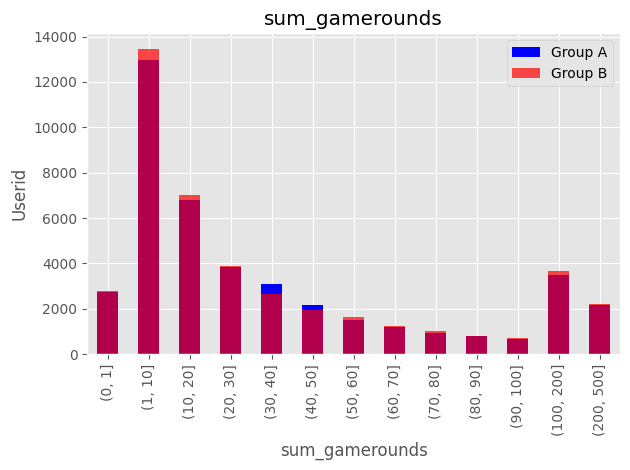

In [163]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'sum_gamerounds')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('sum_gamerounds')
ax.set_ylabel('Userid')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

In [167]:

boot_1d = []
for i in range(500):
  boot_mean = data.retention_1.sample(frac=1, replace=True).groupby(data.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.446147  0.440669
retention_1  0.445655  0.446242
retention_1  0.451055  0.446182
retention_1  0.449339  0.443724
retention_1  0.447660  0.443971
...               ...       ...
retention_1  0.451828  0.441675
retention_1  0.450182  0.437989
retention_1  0.449506  0.442342
retention_1  0.446028  0.437294
retention_1  0.443646  0.439470

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 1-day retention')

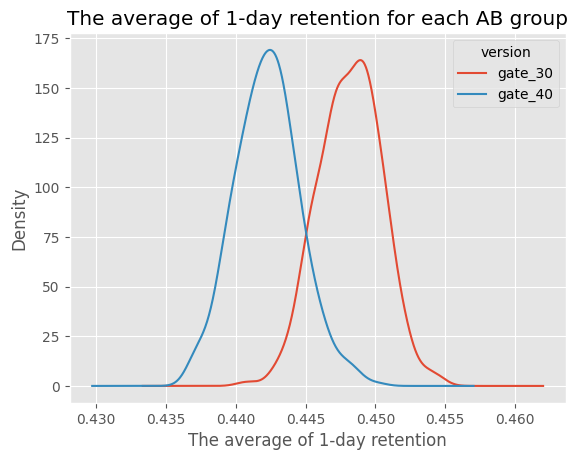

In [168]:

ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

Text(0.5, 1.0, 'Zooming % difference')

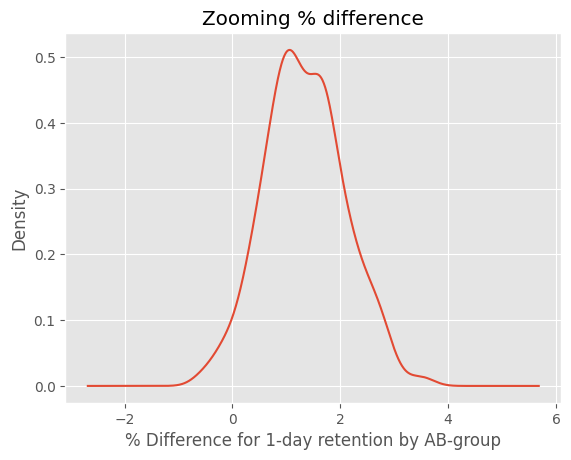

In [169]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference')

In [171]:
data.groupby('version')['retention_7'].sum() / data.groupby('version')['retention_7'].count()
     

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [173]:
boot_7d = []
for i in range(500):
  boot_mean = data.retention_7.sample(frac=1, replace=True).groupby(data.version).mean()
  boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100
     

version       gate_30   gate_40
retention_7  0.190703  0.183780
retention_7  0.191759  0.181666
retention_7  0.188941  0.178757
retention_7  0.194929  0.181874
retention_7  0.191575  0.180920


0.998


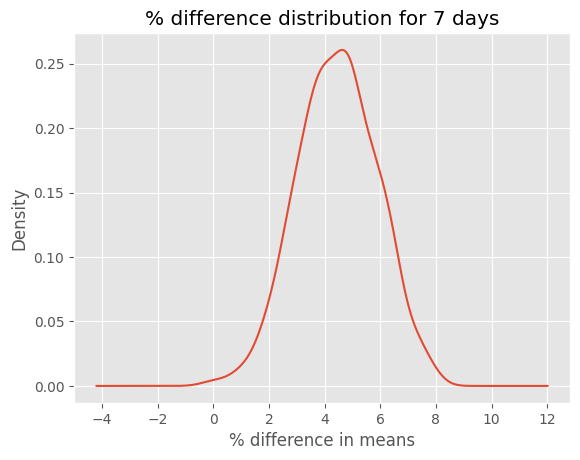

In [174]:
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')
ax.set_title('% difference distribution for 7 days')

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(prob)

Вывод:
Версия ворота- 30 более приоритетна по сумме игровых раундов, и по удержанию в 1ый день.